In [1]:
import matplotlib.pyplot as plt
import numpy as np

Load samples from text file<br>
Should be in 2D array format<br><br>
`
[[ float, float, int ], ...]
`

In [2]:
samples = np.loadtxt("./data/data11.txt", delimiter=",")
samples

array([[ 5.4463 , -1.7124 ,  1.     ],
       [ 1.2837 , -0.31709,  1.     ],
       [ 3.9605 ,  5.4438 ,  1.     ],
       ...,
       [11.842  ,  3.48   ,  2.     ],
       [ 8.9164 ,  1.5883 ,  2.     ],
       [12.322  ,  2.1162 ,  2.     ]])

### Step 1.
Begin with a decision on the value of k = number of clusters<br><br>
2 clusters is a good start, but have fun with it! Just dont go too high! 😂😂

In [3]:
k = 4  # number of clusters (k)

### Step 2.
Put any initial partition that classifies the data into k clusters.<br>
You may assign the training samples randomly, or systematically<br>

I decided to pick the training samples, or centroids, randomly<br>
by card shuffling the data set, then grabbing the k'th element from each cluster.<br>
Those elements will be the centroids<br>

Turns out there is no need for the labels in the initial sample data set,<br>
that's there so we can compare our generated clusters to the actual clusters<br>

To get the initial centroids, all you have to do is shuffle the samples, make sure there are<br>
only two columns in the sample set, and for each k, or number of clusters:<br>
&nbsp;&nbsp;&nbsp;&nbsp;grab the first sample, or the first row,<br>
&nbsp;&nbsp;&nbsp;&nbsp;append the value k to the end of that sample,<br>
&nbsp;&nbsp;&nbsp;&nbsp;and let that be a centroid



In [4]:
def init_centroids(samples: np.ndarray, num_clusters: int) -> np.ndarray:
    shuffled_samples = np.copy(samples)    # copy the sample set first
    # only want the first two columns in the samples set, turns out we dont need labels
    shuffled_samples = shuffled_samples[ :,:2 ] if shuffled_samples.shape[1] > 2 else shuffled_samples
    np.random.shuffle(shuffled_samples)    # then card shuffle the data set
    # grab every k'th sample, or row, from the shuffled samples, then append the value k on the end of the row we grabbed
    # the k value at the end will represent the label for the centroids, 
    centroids = [ np.hstack( (shuffled_samples[k], [k+1]) ) for k in range(num_clusters) ]

    return np.array(centroids, dtype=np.float32)

centroids = init_centroids(samples, k)
centroids

array([[ 5.8764 ,  0.70426,  1.     ],
       [ 5.1635 , -3.2898 ,  2.     ],
       [10.209  ,  4.4663 ,  3.     ],
       [ 7.193  ,  5.0399 ,  4.     ]], dtype=float32)

#### Here's a plot that shows the k clusters and the centroids<br>
Notice the red dots, those are the centroids<br>

The centroids act as separate clusters. Any sample points nearby<br>
a centroid will be assigned to that centroid, forming a cluster.<br>

The goal is to move those red dots to the center<br>
of their clusters as possible.

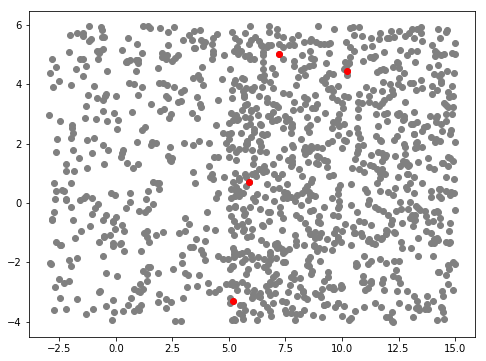

In [5]:
plt.figure(figsize=(8, 6))
plt.scatter(samples[:,0], samples[:,1], c='gray')
plt.scatter(centroids[:,0], centroids[:,1], c="r")

### Step 3.
Take each sample in sequence and compute its distance from the centroid of each<br>
of the clusters.

I decided to compute the distance by forming a 3D array with shape `(centroids.shape[0], samples.shape[0], 2)`<br>
`centroids.shape[0]` and `samples.shape[0]` is the same thing as `len(centroids)` and `len(samples)`<br>
And the shape is dependent on the number of centroids, and the number of samples<br>

So for example, if we have 2 centroids and 5 samples, we would get a 3D array with shape (2, 5, 2)<br>
Two 2D arrays, 5 rows in each 2D array, and 2 columns in each 2D array
<br>
```
[[
    # matrix 1
    [0.0, 0.0],
    [0.0, 0.0],
    [0.0, 0.0],
    [0.0, 0.0],
    [0.0, 0.0],
],
[
    # matrix 2
    [0.0, 0.0],
    [0.0, 0.0],
    [0.0, 0.0],
    [0.0, 0.0],
    [0.0, 0.0], 
]]
```
<br>
Then I just used that distance formula $\sqrt{(x2 - x1)^2 + (y2 - y1)^2}$
<br>
and for each centroid, compute the distance between every sample<br><br>
for readability, i went with a nested for loop<br>
but theres a matrix trick you can do to make this shorter and quicker!<br>
but at the expense of readability and ease of understanding 😢

In [6]:
def compute_distances(samples, centroids):
    # so you can send samples param without slicing the labels off first
    sliced_samples = samples[ :,:2 ] if samples.shape[1] > 1 else samples
    sliced_centroids = centroids[ :,:2 ] if centroids.shape[1] > 1 else centroids
    # the distances matrix, a 3D matrix initialized to all 0.0 values
    distances = np.zeros((centroids.shape[0], samples.shape[0], 2), dtype=np.float32)

    for i,centroid in enumerate(sliced_centroids):
        for j,sample in enumerate(sliced_samples):
            distances[i,j] = (sample - centroid)**2 # matrix subtract sample and centroid, then square power the resulting matrix
    
    distances = np.sum(distances, axis=2) # add both matrices together
    distances = np.sqrt(distances)        # square root the matrix

    return distances

sample_distances = compute_distances(samples, centroids)
sample_distances

array([[ 2.4546347,  4.7048965,  5.112134 , ...,  6.57975  ,  3.1659322,
         6.5984344],
       [ 1.60255  ,  4.8877244,  8.816064 , ...,  9.5096035,  6.1546826,
         8.970449 ],
       [ 7.801259 , 10.126292 ,  6.3244963, ...,  1.9077415,  3.154948 ,
         3.1603386],
       [ 6.9745617,  7.976037 ,  3.2576358, ...,  4.903722 ,  3.8579333,
         5.903784 ]], dtype=float32)

### Step 4.
Assign each of the remaining (N-k) training samples to the cluster with the nearest<br>
centroid.<br>

If a sample is not currently in the cluster with the closest centroid, switch<br>
this sample to that cluster and update the centroid of the cluster gaining the new sample<br>
and the cluster losing the sample.<br>

I decided to make this easy and use a numpy function called `argmin()`,<br>
which gives you the indices of the minimial values in whatever axis you tell it to process<br>
axis 0 is column-wise, axis 1 is row-wise, and axis 2 is i have no idea! 😂<br>

I cleverly designed the distance matrix so that theres only `k` amount of rows in the<br>
distance matrix. Row 0 correlates to centroid 1, Row 1 correlates to centroid 2, and so on<br>
By using `argmin(axis=0)`, I can easily figure out which sample point belongs to which centroid.<br>

argmin(axis=0) will go through every column in the distance matrix and give you the indices that correspond<br>
to the least values in each column.<br>

Here's an example 
```
[[     0.     3.9554372                                 ]   # Centroid 1
 [                           0.     1.2762772  3.91072  ]]  # Centroid 2
       ^          ^          ^          ^         ^
 [     0          0          1          1         1     ]
```

In [7]:
small_sample_distances = compute_distances(samples[:5], centroids)
print(f"Distance Matrix for first 5 samples\n{small_sample_distances}\n")
small_samples_labels = np.argmin(small_sample_distances[:5], axis=0)
print(f"First 5 samples and their corresponding centroids\n{small_samples_labels}")

Distance Matrix for first 5 samples
[[ 2.4546347  4.7048965  5.112134   7.26924    4.681565 ]
 [ 1.60255    4.8877244  8.816064   9.073345   7.501387 ]
 [ 7.801259  10.126292   6.3244963 11.069807   8.057231 ]
 [ 6.9745617  7.976037   3.2576358  8.155136   5.197819 ]]

First 5 samples and their corresponding centroids
[1 0 3 0 0]


After each assignment, recompute the centroid of the gaining cluster.<br>

This is where we recompute the new centroids locations. Using the centroid labels I generated from argmin()<br>
and the numpy mean() function, its pretty simple.<br>

For each centroid, compute the mean of all the samples that belong to it, then move the centroid to those<br>
new mean coordinates

and a quick note, `samples[ labels == k+1 ]` is a cool way of saying<br>
In the samples data set, select only the samples that correspond to centroid `k+1` 😛

In [8]:
def compute_centroids(samples, samples_labels, centroids) -> np.ndarray:
    # for each centroid, compute the mean of all the samples, result is centroids new location
    recomputed_centroids = []

    for k in range(centroids.shape[0]):
        new_centroid = samples[ samples_labels == k+1 ].mean(axis=0)
        recomputed_centroids.append( np.hstack(( new_centroid, [k+1] )) )
    # recomputed_centroids = [ samples[ samples_labels == k+1 ].mean(axis=0) for k in range(centroids.shape[0]) ]

    return np.array(recomputed_centroids, dtype=np.float32)

# this is to actually update the labels in the samples data set, i didnt do this in the previous cells
samples_labels = np.argmin( sample_distances, axis=0 ) + 1

# compute the new centroids
new_centroids = compute_centroids(samples, samples_labels, centroids)
new_centroids

array([[ 4.8480535,  1.0123672,  1.5203252,  1.       ],
       [ 5.203197 , -2.5912979,  1.5126354,  2.       ],
       [12.292915 ,  2.1885617,  2.       ,  3.       ],
       [ 4.9358673,  4.669849 ,  1.482353 ,  4.       ]], dtype=float32)

Repeat steps 3-4 until coverage is achieved, that is until a pass through the training sample cause no new assignment<br>

The plot below is with only one iteration. You would have to run a loop that would<br>
compute the distances and centroid mean coordinates until the centroid coordinates are<br>
the same as the last iteration coordinates 🥱🥱

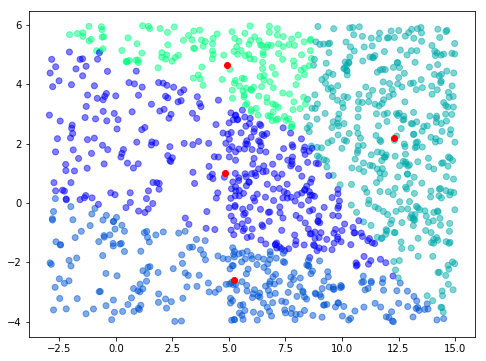

In [9]:
color_map = "RdBu" if k <= 2 else "winter" 
plt.figure(figsize=(8, 6))
plt.scatter(samples[:,0], samples[:,1], c=samples_labels, cmap=color_map, alpha=0.5)
plt.scatter(new_centroids[:,0], new_centroids[:,1], c="r")

And another cool thing, you can change the `cmap` value in `plt.scatter()` with these values! Have fun with it! 😂😂😂
```python
cmaps = [('Perceptually Uniform Sequential', [
            'viridis', 'plasma', 'inferno', 'magma', 'cividis']),
         ('Sequential', [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),
         ('Sequential (2)', [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']),
         ('Diverging', [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']),
         ('Cyclic', ['twilight', 'twilight_shifted', 'hsv']),
         ('Qualitative', [
            'Pastel1', 'Pastel2', 'Paired', 'Accent',
            'Dark2', 'Set1', 'Set2', 'Set3',
            'tab10', 'tab20', 'tab20b', 'tab20c']),
         ('Miscellaneous', [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])]
```

### And finally, here's the kmeans function

In [10]:
def kmeans(samples: np.ndarray, k: int) -> tuple:
    i = 0   # kmeans iteration count just to keep track 
    # we only want the first two columns of the data set if it happens to be more than 2 columns wide
    if samples.shape[1] > 2:
        samples = samples[ :,:2 ]

    centroids = init_centroids(samples, k)
    prev_centroids = np.empty((k,3), dtype=np.float32)
    samples_labels = np.zeros((samples.shape[0],)) # the labels computed from argmin()
    # if you want, you can plot the graph here to show a before kmeans picture

    while not np.all(centroids == prev_centroids):
        prev_centroids = centroids.copy()
        distances = compute_distances(samples, centroids)
        samples_labels = np.argmin(distances, axis=0) + 1
        centroids = compute_centroids(samples, samples_labels, centroids)
        i += 1

    return (samples_labels, centroids, i)

## Iris Data Set

Contains 50 flowers of 3 species: Setosa, Versicolor and Virginica<br>
The goal is to use kmeans to predict which flowers belong to these species<br>

Column{0} -> Sepal.Length  |  Column{1} -> Sepal.Width  |  Column{2} -> Petal.Length  |  Column{3} -> Petal.Width   

Number of kmeans iterations performed for Sepal: 6
Number of kmeans iterations performed for Petal: 3


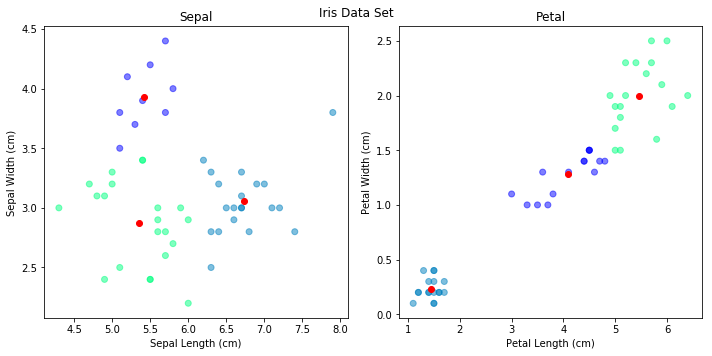

In [11]:
k = 3 # num clusters, you can change this! Just dont go too high!
color_map = "winter"
iris_data = np.loadtxt("./data/iris_data_set.csv", delimiter=",")
iris_data = [ iris_data[ :,:2 ], iris_data[ :,2: ] ] # 3D array
iris_titles = ["Sepal", "Petal"]
iris_axes_names = [["Sepal Length (cm)", "Sepal Width (cm)"], ["Petal Length (cm)", "Petal Width (cm)"]]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for i,data in enumerate(iris_data):
    labels, centroids, kmeans_i = kmeans(data, k)
    x_name, y_name = iris_axes_names[i]

    print(f"Number of kmeans iterations performed for {iris_titles[i]}: {kmeans_i}")
    axes[i].set_title(iris_titles[i])
    axes[i].scatter(data[:,0], data[:,1], c=labels, cmap=color_map, alpha=0.5)
    axes[i].scatter(centroids[:,0], centroids[:,1], c="r")
    axes[i].set(xlabel=x_name, ylabel=y_name)

fig.suptitle('Iris Data Set')
fig.tight_layout()
plt.show()


### Zachary's Karate Club Data Set 
A social network of 34 members in a karate club that have documented social links between<br>each other.<br>

The club split into two because of a conflict and now half the members formed a new club<br>
while the other half found another club to join or gave up on karate altogether<br>

Goal is to map out each member's social connection and predict which clubs they will likely end up in

These are data collected from the members of a university karate club by Wayne Zachary. The KarateMatrix.txt matrix represents the presence or absence of ties among the members of the club; the Karate.txt matrix indicates the relative strength of the associations (number of situations in and outside the club in which interactions occurred).

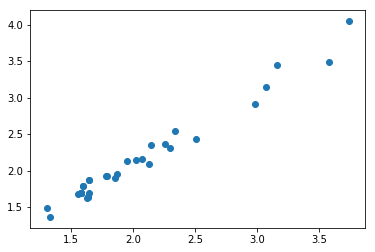

In [64]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import cluster

np.set_printoptions(suppress=True)
k = 2
color_map = "winter"
karate_adjacency_matrix = np.loadtxt("./data/KarateMatrix.txt")

edges = karate_adjacency_matrix.sum(axis=0) # edge centralities
edge_centrality_matrix = np.identity(karate_adjacency_matrix.shape[0]) * edges
laplacian_matrix = edge_centrality_matrix - karate_adjacency_matrix

eig_values, eig_vectors = np.linalg.eig(laplacian_matrix)

eig_vectors = eig_vectors[:, np.argsort(eig_values)]
eig_values = eig_values[np.argsort(eig_values)]
eig_values[np.argsort(eig_values)]

Y = eig_vectors
Y = np.sqrt(XX**2)

std = np.std(edges)
mean = np.mean(edges, axis=0)
zscore = (edges - mean) / std
# np.sqrt(zscore**2)[:,np.newaxis]
# Y[:,:1]
XX = euclidean_distances(karate_adjacency_matrix, Y.T)

# edges - mean
# print(eig_values[0:5])
# eig_vectors[eig_vectors[:,1] > 0]

plt.scatter(XX[:,0], XX[:,1])
plt.show()

In [14]:
kmeanz = cluster.KMeans(n_clusters=2, random_state=1234)
X = kmeanz.fit_transform(adjacency_matrix)
X
# plt.scatter(X[:,0], X[:,1], c=kmeanz.labels_, cmap="prism")
# plt.show()

NameError: name 'adjacency_matrix' is not defined

In [15]:
A = np.array([
  [0, 1, 1, 0, 0, 0, 0, 0, 1, 1],
  [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
  [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
  [0, 0, 0, 1, 1, 0, 1, 1, 0, 0],
  [0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
  [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 1, 0]])

# diagonal matrix
D = np.diag(A.sum(axis=1))

# graph laplacian
L = D-A

# eigenvalues and eigenvectors
vals, vecs = np.linalg.eig(L)

# sort these based on the eigenvalues

vecs = vecs[:,np.argsort(vals)]
vals = vals[np.argsort(vals)]
print(vals)
# kmeans on first three vectors with nonzero eigenvalues
kmeans = KMeans(n_clusters=2)
kmeans.fit(vecs[:,1:4])
colors = kmeans.labels_

print("Clusters:", colors)


[0. 0. 1. 1. 3. 3. 3. 3. 5. 5.]


NameError: name 'KMeans' is not defined